##Customer Churn Prediction + Retention Strategy

###BY SHIVANI UPPALA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset (upload 'WA_Fn-UseC_-Telco-Customer-Churn.csv' to Colab first)
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn (1).csv')

In [3]:
# Basic overview
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe(include='all'))
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

Dataset Shape: (7043, 21)

First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Streami

In [4]:
# Clean data: Handle spaces in 'TotalCharges' and convert to numeric
df['TotalCharges'] = df['TotalCharges'].str.replace(' ', '')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})  # Binary target

In [5]:
# Drop customerID (not useful)
df = df.drop('customerID', axis=1)

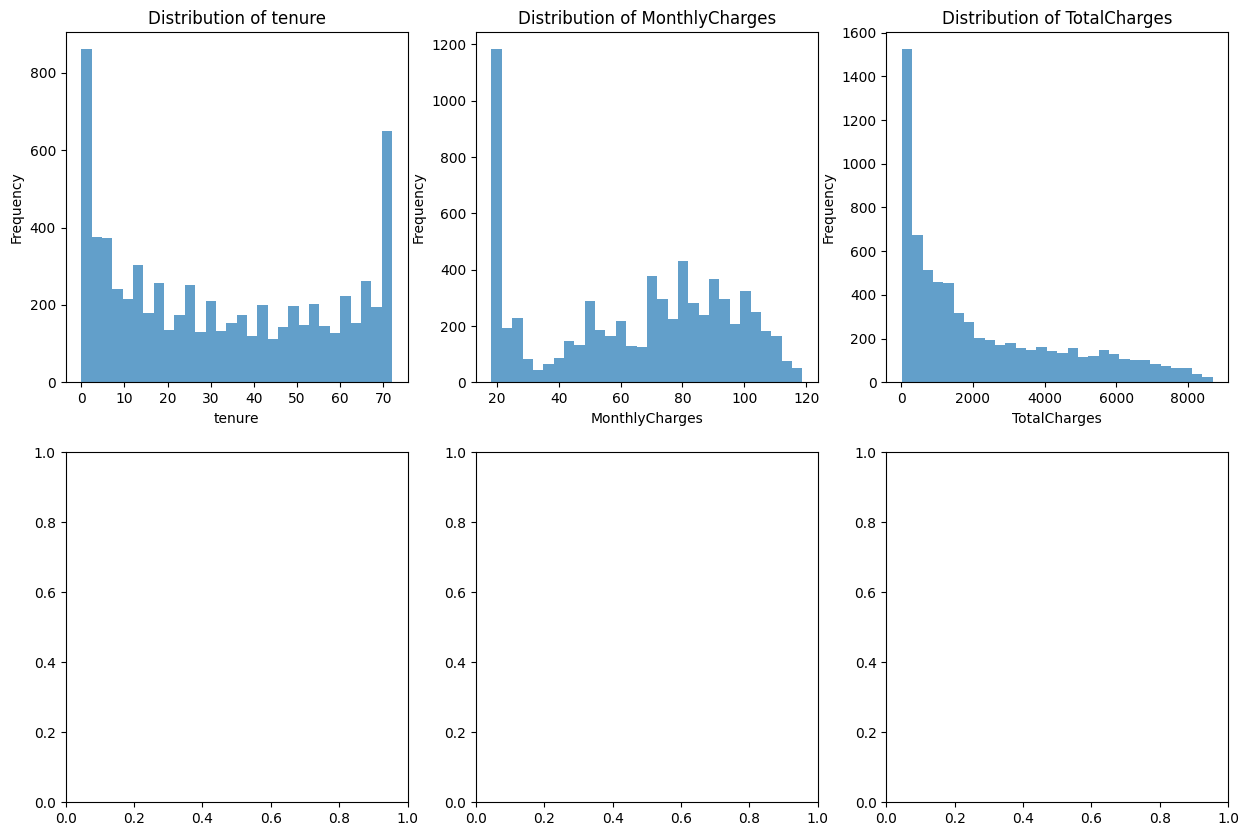

In [6]:
# Univariate Analysis: Distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for i, col in enumerate(numerical_cols):
    axes[0, i].hist(df[col].dropna(), bins=30, alpha=0.7)
    axes[0, i].set_title(f'Distribution of {col}')
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel('Frequency')

In [7]:
# Categorical countplots (select a few key ones)
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService']
for i, col in enumerate(categorical_cols):
    if i < 6:  # Limit to fit subplot
        sns.countplot(data=df, x=col, ax=axes[1, i//3])  # Rough grid
        axes[1, i//3].set_title(f'Countplot of {col}')
        axes[1, i//3].tick_params(axis='x', rotation=45)

In [8]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

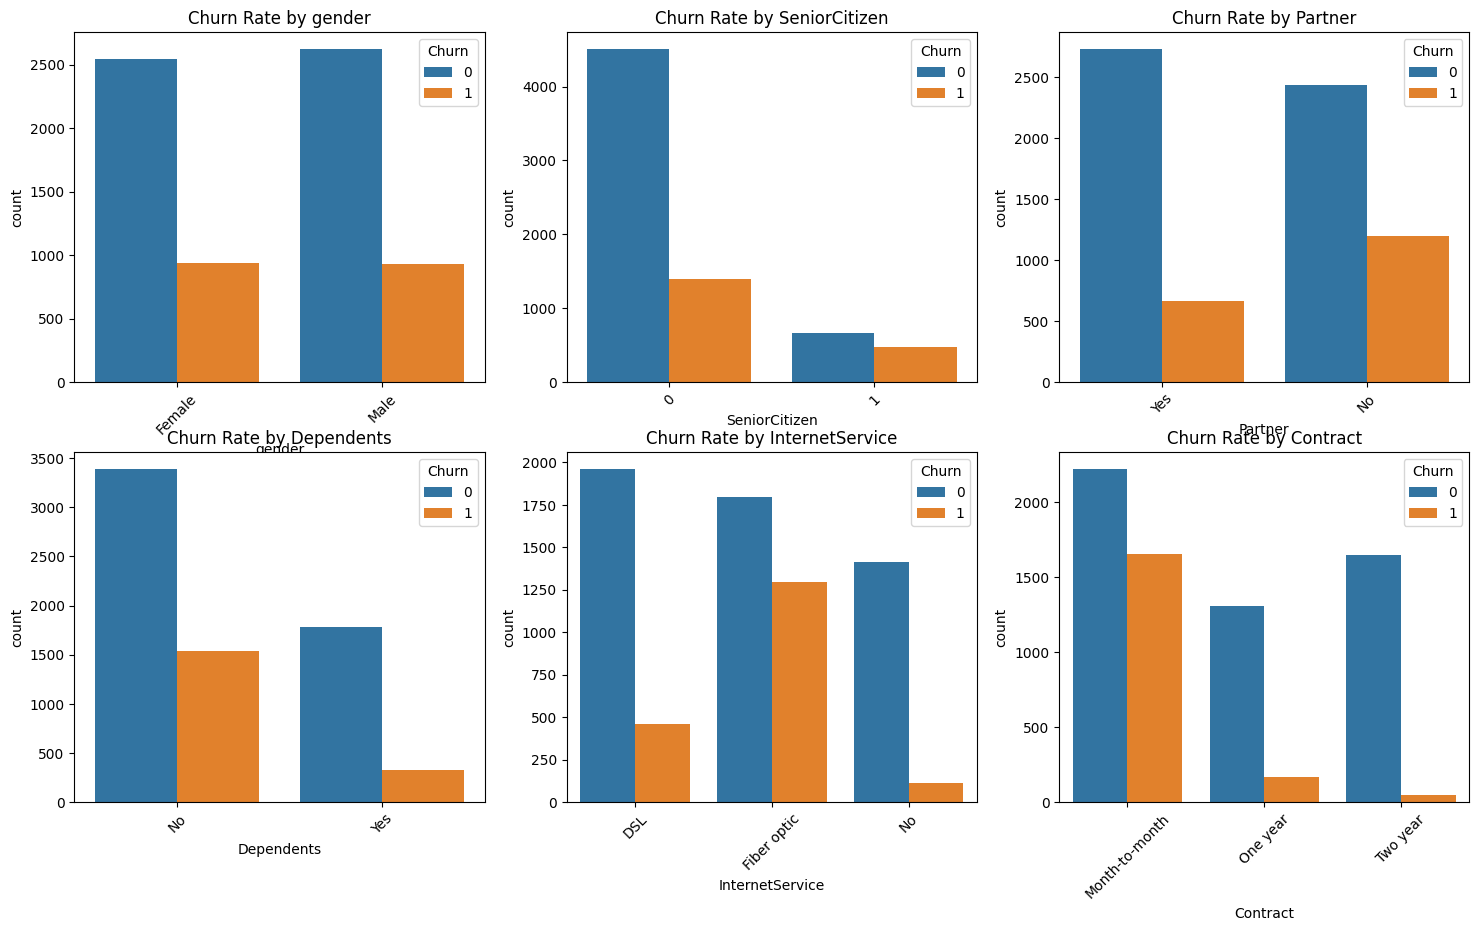

In [9]:
# Bivariate Analysis: Churn by categories
key_cats = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'Contract']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, col in enumerate(key_cats):
    row, col_idx = i // 3, i % 3
    sns.countplot(data=df, x=col, hue='Churn', ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Churn Rate by {col}')
    axes[row, col_idx].tick_params(axis='x', rotation=45)

In [10]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

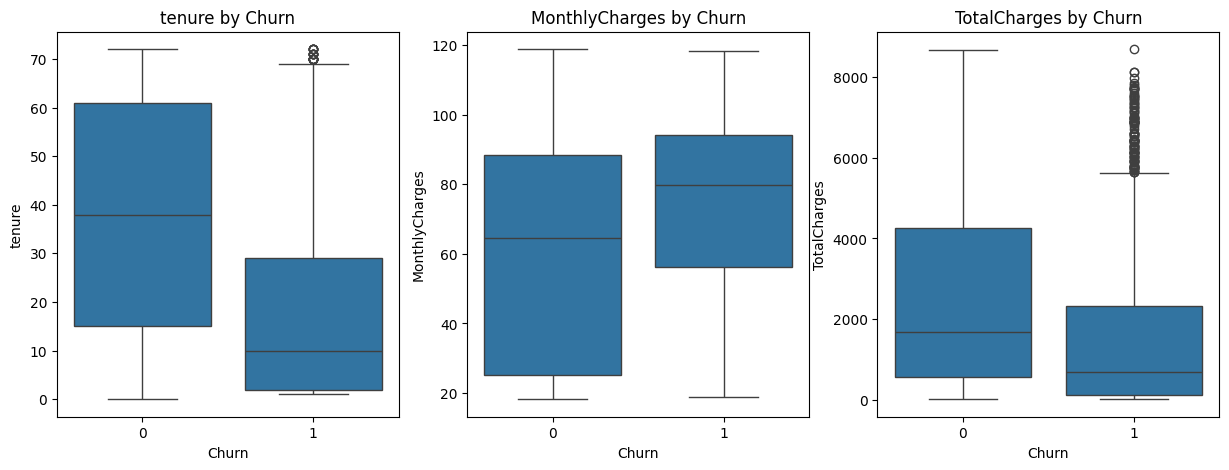

In [11]:
# Numerical vs Churn: Boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x='Churn', y=col, ax=axes[i])
    axes[i].set_title(f'{col} by Churn')

In [12]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [13]:
# Overall Churn Rate
churn_rate = df['Churn'].value_counts(normalize=True) * 100
print("\nOverall Churn Rate:")
print(churn_rate)


Overall Churn Rate:
Churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64


In [14]:
# Correlation Matrix and Heatmap
# One-hot encode categoricals for correlation (drop high-cardinality like PaymentMethod for simplicity)
df_encoded = pd.get_dummies(df.drop(['PaymentMethod', 'MultipleLines'], axis=1))  # Drop some to reduce dims
corr_matrix = df_encoded.corr()

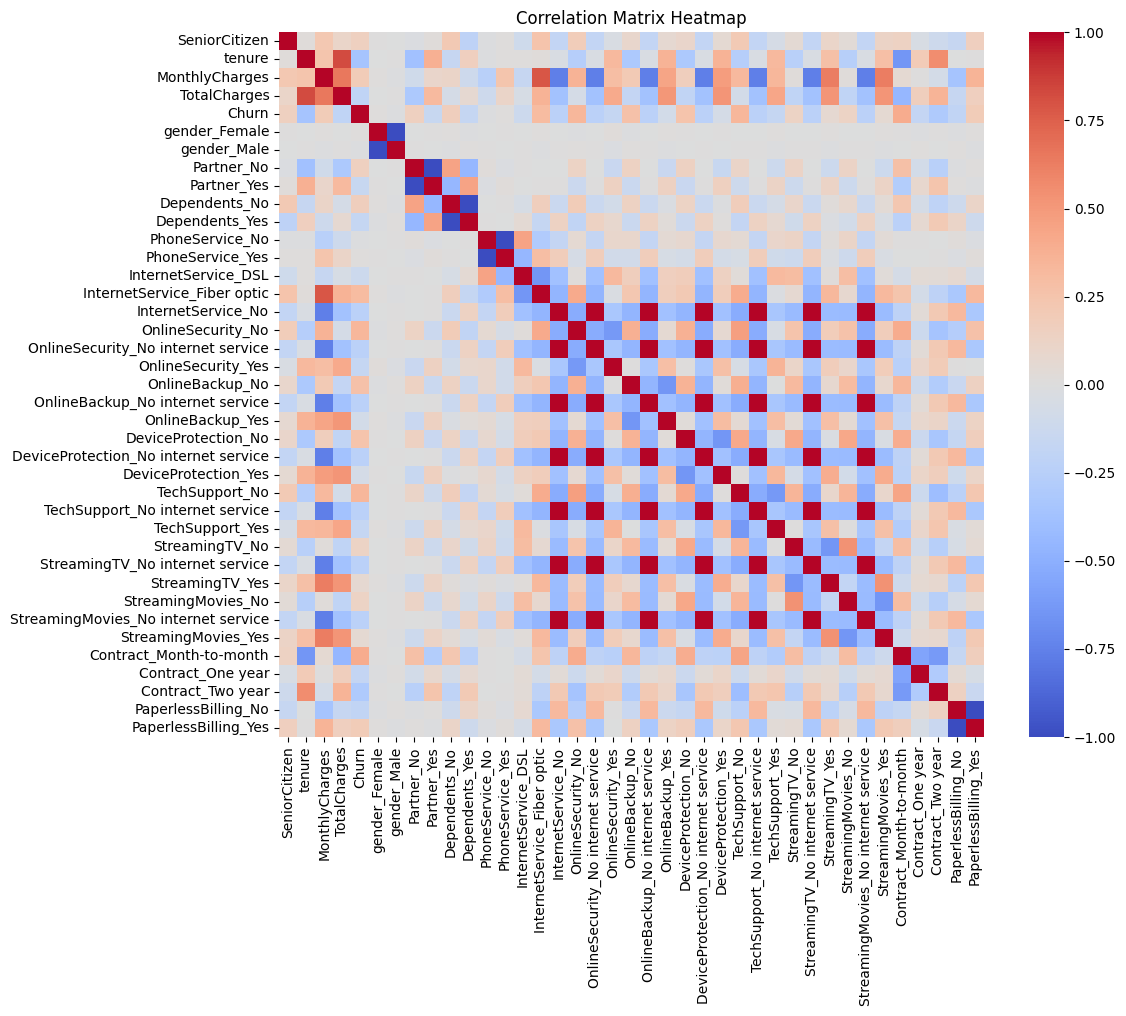

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

In [16]:
# Print top correlations with Churn
churn_corr = corr_matrix['Churn'].sort_values(ascending=False)
print("\nTop Correlations with Churn:")
print(churn_corr.head(10))


Top Correlations with Churn:
Churn                          1.000000
Contract_Month-to-month        0.405103
OnlineSecurity_No              0.342637
TechSupport_No                 0.337281
InternetService_Fiber optic    0.308020
OnlineBackup_No                0.268005
DeviceProtection_No            0.252481
MonthlyCharges                 0.193356
PaperlessBilling_Yes           0.191825
Dependents_No                  0.164221
Name: Churn, dtype: float64


In [17]:
# Feature Importance for Categoricals: Chi-Squared Test
print("\nChi-Squared p-values for Categorical Features vs Churn (low p = significant):")
for col in ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'Contract', 'OnlineBackup']:
    contingency = pd.crosstab(df[col], df['Churn'])
    chi2, p, dof, ex = chi2_contingency(contingency)
    print(f"{col}: p-value = {p:.4f}")


Chi-Squared p-values for Categorical Features vs Churn (low p = significant):
gender: p-value = 0.4866
SeniorCitizen: p-value = 0.0000
Partner: p-value = 0.0000
Dependents: p-value = 0.0000
InternetService: p-value = 0.0000
Contract: p-value = 0.0000
OnlineBackup: p-value = 0.0000


In [18]:
# Insights for Retention Strategy (based on EDA)
print("\n=== Retention Strategy Insights ===")
print("1. High churn in month-to-month contracts: Offer incentives for longer contracts (e.g., discounts for 1-2 year).")
print("2. Fiber optic internet users churn more: Improve service quality or bundle with backups.")
print("3. Seniors and no dependents churn higher: Targeted senior discounts or family plans.")
print("4. Higher monthly charges correlate with churn: Tiered pricing or loyalty rebates.")
print("5. Low tenure customers: Onboarding campaigns with tutorials and support.")
print("6. Overall churn ~26%: Focus on top 3-5 features from correlations for modeling.")


=== Retention Strategy Insights ===
1. High churn in month-to-month contracts: Offer incentives for longer contracts (e.g., discounts for 1-2 year).
2. Fiber optic internet users churn more: Improve service quality or bundle with backups.
3. Seniors and no dependents churn higher: Targeted senior discounts or family plans.
4. Higher monthly charges correlate with churn: Tiered pricing or loyalty rebates.
5. Low tenure customers: Onboarding campaigns with tutorials and support.
6. Overall churn ~26%: Focus on top 3-5 features from correlations for modeling.
